In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
def nuInt(x, k):
    #print ((k-1)*((k**2-6*k+6.)))
    #print ((k**2-3*k+2)*np.power(x,2)+2*(k-1.)*x+2)
    #return -np.power((x+1.), (1-k))*((k**2-3.*k+2)*np.power(x,2)+2*(k-1.)*x+2)/((k-1.)*(k**2-5*k+6.))
    #this is assuming k=-3 
    #return -1./(2.*(r_lim+1.)**2)
    return np.power(x,3-k)/(3-k)

def nuProfile(Ntot,radii,k=2.9m):
    nu0 = Ntot / (4.*np.pi*(nuInt(radii[-1], k)-nuInt(radii[0], k)))
    print nu0
    #print 'nu0:' ,nu0
    return (nu0*(nuInt(radii[1:],k) - nuInt(radii[:-1],k))).astype(int)

#radii = np.append(0.,np.logspace(1.,3.,11))
radii = np.logspace(1.,3.,11)
#plt.xscale('log')
#plt.yscale('log')
#plt.plot(radii[1:],nuProfile(1000,radii),'b+')
print "log spaced bins"
print radii
print nuProfile(1000,radii)
print np.sum(nuProfile(1000,radii))
radii_lin = np.linspace(10,1000, 11)
print "lin spaces bins"
print radii_lin
print nuProfile(1000,radii_lin)
print np.sum(nuProfile(1000,radii_lin))

# here I conclude that the logspace is not ideal - if we want nicer bins, we should create ones that
# sample the volume in a log way - so that our sample is equally spread out 


log spaced bins
[   10.            15.84893192    25.11886432    39.81071706    63.09573445
   100.           158.48931925   251.18864315   398.10717055   630.95734448
  1000.        ]
27.1464828353
[9 9 8 8 8 7 7 7 6 6]
27.1464828353
75
lin spaces bins
[   10.   109.   208.   307.   406.   505.   604.   703.   802.   901.
  1000.]
27.1464828353
[45 10  6  4  3  2  2  1  1  1]
27.1464828353
75


In [36]:
def defineRadii(nTot=1000.,rOut=1000.,nAnn=10,k=2.9):
    radii = np.array([1.])
    nu0 = nTot*(3.-k)/(4*np.pi*(rOut**(3.-k)-1.))
    c = (3-k)*nTot/(4*np.pi*nu0*nAnn)
    for i in range(nAnn):
        radii = np.append(radii,(c+radii[i]**(3-k))**(1./(3-k)))
    return radii
    
print defineRadii()

[  1.00000000e+00   2.58259287e+00   6.14301895e+00   1.36358662e+01
   2.85362998e+01   5.67608209e+01   1.08013279e+02   1.97700912e+02
   3.49599450e+02   5.99485613e+02   1.00000000e+03]


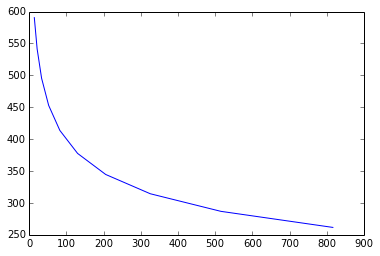

In [27]:
def sigmaProfile(radii,sigMax=1000,k=-.2):
    
    return sigMax*(1.+0.5*(radii[1:]+radii[:-1]))**k

plt.plot(1.+0.5*(radii[1:]+radii[:-1]),sigmaProfile(radii))

In [28]:
def createMockData(radii,Ntot=1000,sigMax=1000,kindex=-3,sigmaindex=-0.2): #total Ngals, no of shells
    clusterData = np.zeros((Ntot,5))
    counter=0
    density = nuProfile(Ntot,radii,k=kindex)
    sig = sigmaProfile(radii,sigMax=1000,k=sigmaindex)
    
    for shell,dens in enumerate(density):
        #generate positions
        phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        theta = np.arccos(cosTheta)
        u = np.random.uniform(radii[shell]**3,radii[shell+1]**3,dens) #cuberoot([rin,rout])
        r = np.power(u,1./3)
        
        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        z = r*cosTheta
        
        #generate velocities
        
        speed = sig[shell]*np.random.randn(dens)
        #phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        #theta = np.arccos(cosTheta)
        
        v=speed*cosTheta   
        
        #replace with vstack,append
        clusterData[counter:counter+dens]=np.hstack((shell*np.ones(dens).reshape((dens,1)),x.reshape((dens,1)),y.reshape((dens,1)),z.reshape((dens,1)),v.reshape((dens,1))))
        counter += dens
    
    print counter
    return clusterData[:counter],density,sig

In [29]:
cluster,density,sigma = createMockData(np.append(0,np.logspace(-2,1,11)))

print np.logspace(-2,1,11)

plt.scatter(cluster[:,1],cluster[:,2],s=np.fabs(cluster[:4])/5)

ValueError: could not broadcast input array from shape (128,5) into shape (107,5)

In [6]:
import pandas as pd

clusterPd = pd.DataFrame(cluster)

clusterPd.describe()

,0,1,2,3,4
count,994.000000,994.000000,994.000000,994.000000,994.000000
mean,5.693159,-0.025881,-0.024694,-0.038884,52.580055
std,2.078862,0.979960,0.956779,1.003943,741.213093
min,0.000000,-5.908787,-4.680436,-7.796008,-3133.809266
25%,4.000000,-0.211761,-0.218818,-0.170836,-273.311379
50%,6.000000,-0.003869,-0.004193,-0.000696,14.626836
75%,7.000000,0.144071,0.165231,0.156901,348.657303
max,10.000000,7.653392,8.014847,8.520169,4572.619881


In [7]:
clusterPd.to_csv('mock_cluster.csv')